# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
simulation_mode = "stim"
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

Connections between Thalami removed!:
 [[0.6059682  0.        ]
 [0.         0.31177142]]
Removing BG -> Cortex connections with max:
5561.70581402219
Removing BG <- Cortex connections with max:
5202.36821426155

Connectome used for simulations: 
Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections


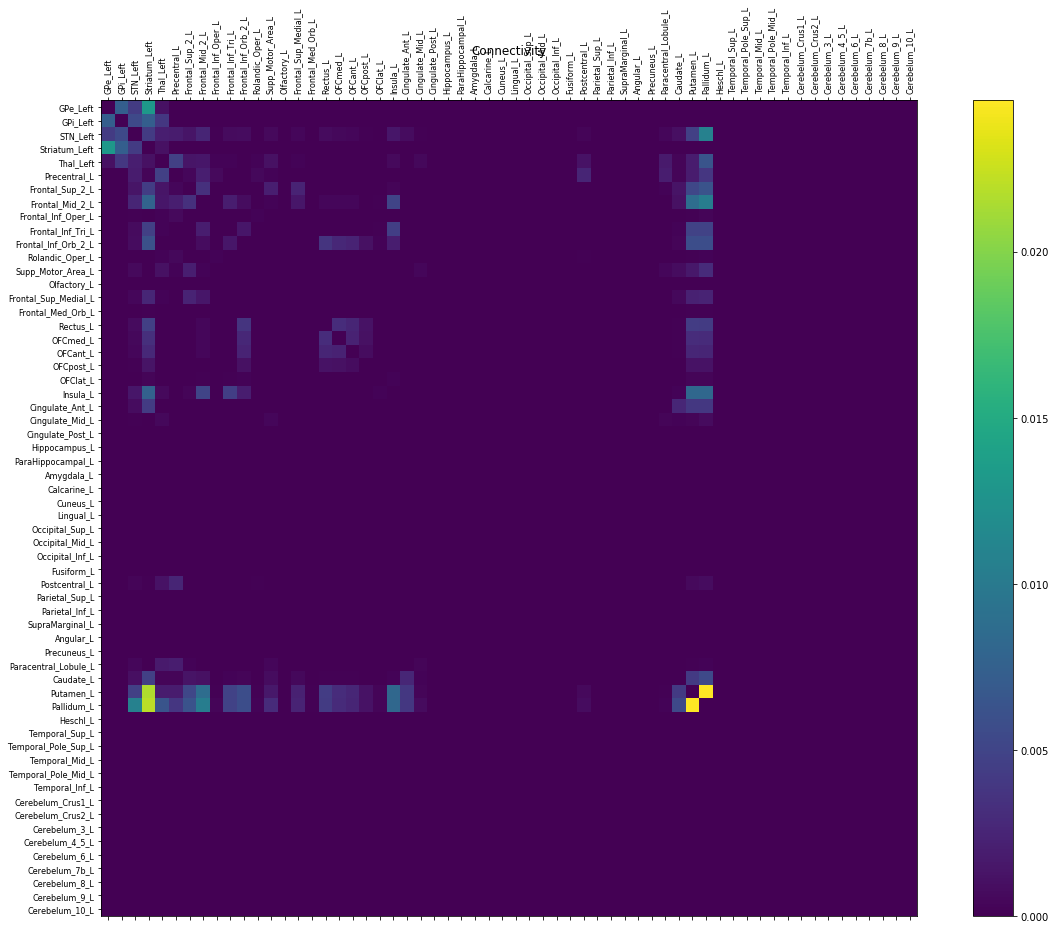

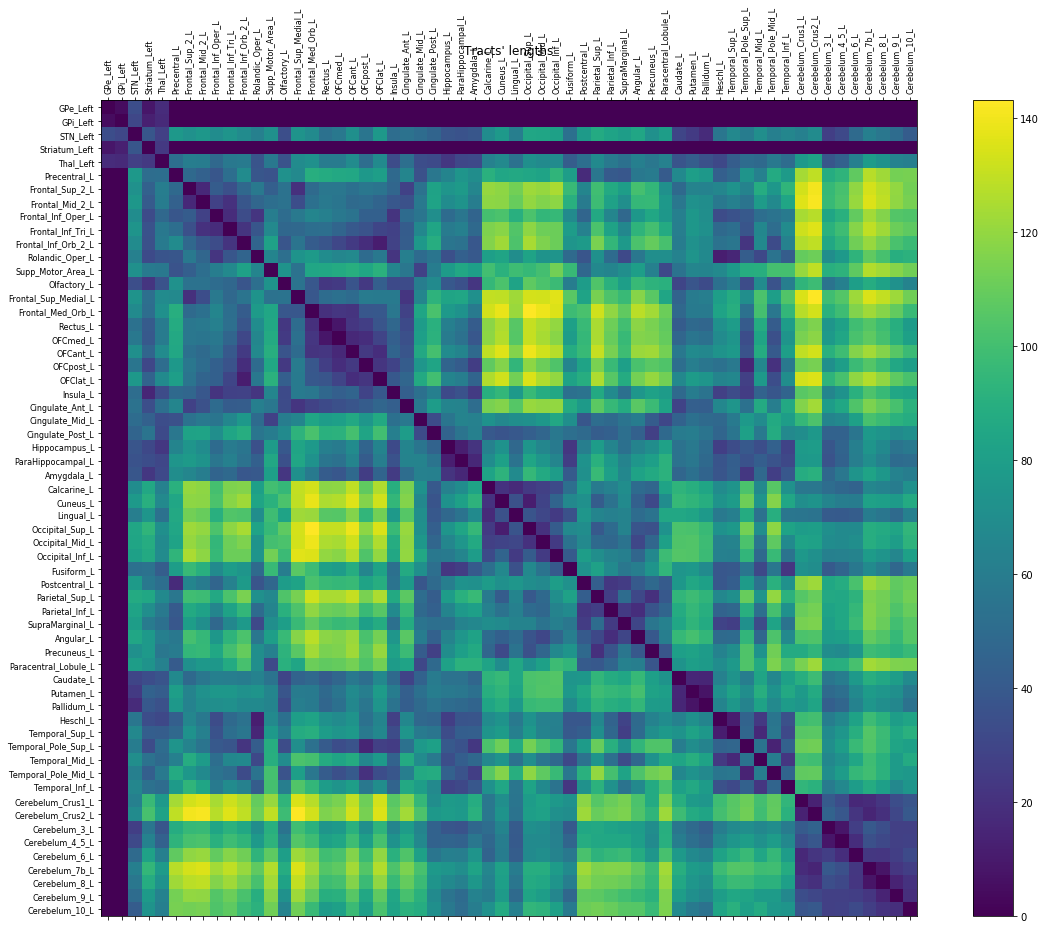

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG

# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# # ????Remove the second Thalamus????:
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
print("Connections between Thalami removed!:\n", wTVB[[8,9], :][:, inds_Th] / wTVB.max())
wTVB = np.delete(wTVB, inds_Th, axis=0)
wTVB = np.delete(wTVB, inds_Th, axis=1)
tlTVB = np.delete(tlTVB, inds_Th, axis=0)
tlTVB = np.delete(tlTVB, inds_Th, axis=1)
rlTVB = np.delete(rlTVB, inds_Th, axis=0)
cTVB = np.delete(cTVB, inds_Th, axis=0)

number_of_regions = len(rlTVB)
speed = 4.0
min_tt = speed * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB)
connTVB.speed = np.array([speed])

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connectivity = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                            centres=connTVB.centres[sliceLeft],
                            weights=connTVB.weights[sliceLeft][:, sliceLeft],
                            tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft])
scaleBGoptTOtvb = 0.00205875
connectivity.weights *= scaleBGoptTOtvb
connectivity.speed = connTVB.speed
connectivity.configure()


#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-6])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond = np.load(os.path.join(outputs_path, "tvb_init_cond_left_noVermis.npy"))  # "tvb_init_cond.npy", "tvb_init_cond_left.npy"
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations: \nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections")
plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [3]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config, set_defaults=False)



# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, 
                                    "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'method': "all_to_all", "allow_self_connections": True, "force_multiple_weights": False}

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe", "Igpi" and CxI
     "synapse_model": synapse_model, "conn_spec": conn_spec,#.update({"p": 0.2}),
     "weight": scaleBGoptTOtvb, "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": I_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": scaleBGoptTOtvb, "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": scaleBGoptTOtvb, "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = ann_model_builder.global_coupling_scaling
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe", "Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids},
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"] + "_spikes"
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build_spiking_network()


ANNarchy 4.6 (4.6.9.7) on linux (posix). 
2021-01-13 20:03:56,624 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-01-13 20:03:56,624 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-01-13 20:03:56,636 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-01-13 20:03:56,636 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-01-13 20:03:57,615 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-01-13 20:03:57,615 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-01-13 20:03:57,641 - INFO - tvb_multiscale.co

In [4]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


## 3. Build the TVB-ANNarchy interface

In [5]:
from tvb_multiscale.tvb_annarchy.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_annarchy_builder = \
    RedWWexcIOBuilder(simulator, annarchy_network, spiking_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_annarchy_mode = "rate"
annarchy_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

tvb_annarchy_builder.global_coupling_scaling = 1.0

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_annarchy_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_annarchy_builder.tvb_delays))

tvb_annarchy_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_annarchy_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes in zip([["IdSN", "IiSN"],                  
                                      "E"],
                                      [ann_model_builder.Istr_nodes_ids, 
                                       E_nodes_ids]):  # ann_model_builder.Estn_nodes_ids
        tvb_annarchy_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "PoissonPopulation", "params": {},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 20.0,
        # Applied outside ANNarchy for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, annarchy_node_id=None)-----------
             "weights": TVBWeightFun(scale=tvb_annarchy_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, annarchy_node_id: tvb_delay_fun(tvb_node_id, annarchy_node_id),
             "receptor_type": "ampa",
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> ANNarchy population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if annarchy_to_tvb:
    tvb_annarchy_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- ANNarchy:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, ann_model_builder.Istr_nodes_ids]):
        #            TVB <- ANNarchy
        tvb_annarchy_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "SpikeMonitor", "params": {},
        # ------------------Properties potentially set as function handles with args (annarchy_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------                 #            TVB <- ANNarchy
        #                    TVB <- ANNarchy
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_annarchy_builder.w_tvb_to_spike_rate = 1.0
# We return from a ANNarchy SpikeMonitor the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_annarchy_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_annarchy_model = tvb_annarchy_builder.build_interface(tvb_to_annarchy_mode=tvb_to_annarchy_mode, annarchy_to_tvb=annarchy_to_tvb)


2021-01-13 20:03:59,042 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-01-13 20:03:59,042 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-01-13 20:03:59,046 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-01-13 20:03:59,046 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-01-13 20:03:59,054 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model PoissonPopulation for R created!
2021-01-13 20:03:59,054 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model PoissonPopulation for R created!
2021-01-13 20:03:59,488 - 

## 3. Configure simulator, simulate, gather results

In [6]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))
print(annarchy_network.print_str(connectivity=True))
print(tvb_annarchy_model.print_str(detailed_output=True, connectivity=False))


Compiling... 
OK 
Compiled! in 5.514042 min

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
ANNarchyNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
ANNarchyRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

ANNarchyPopulation - Label: I 
model: Spiking neuron
200 neurons in population with index: 0
parameters: {'a': array([0.005]), 'b': array([0.585]), 'c': array([-

In [7]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
simulation_length = 110.0
transient = 10.0 # simulation_length/11
# ...and simulate!
t_start = time.time()
simulator.configure(tvb_annarchy_model)

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = 35.0
    
results = simulator.run(simulation_length=simulation_length1, # 35.0 with stimulus application
                         configure_spiking_simulator=False)  # because compilation has already be done

if simulation_mode != "rs":
    # for stimulus application:
    Istim = -200.0
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": Istim + annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"]})
    results2 = simulator.run(simulation_length=50.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"] - Istim})
    results3 = simulator.run(simulation_length=25.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0], results3[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1], results3[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))

Simulating 0.0001 seconds of the network took 0.0014727115631103516 seconds. 
Simulating 0.0001 seconds of the network took 0.00021195411682128906 seconds. 
Simulating 0.0001 seconds of the network took 0.00014162063598632812 seconds. 
Simulating 0.0001 seconds of the network took 0.00014853477478027344 seconds. 
Simulating 0.0001 seconds of the network took 0.0003082752227783203 seconds. 
Simulating 0.0001 seconds of the network took 0.00010800361633300781 seconds. 
Simulating 0.0001 seconds of the network took 0.00019931793212890625 seconds. 
Simulating 0.0001 seconds of the network took 0.00010466575622558594 seconds. 
Simulating 0.0001 seconds of the network took 0.0002899169921875 seconds. 
Simulating 0.0001 seconds of the network took 0.00014638900756835938 seconds. 
Simulating 0.0001 seconds of the network took 0.00032258033752441406 seconds. 
Simulating 0.0001 seconds of the network took 0.000415802001953125 seconds. 
Simulating 0.0001 seconds of the network took 0.000179290771

Simulating 0.0001 seconds of the network took 0.0005750656127929688 seconds. 
Simulating 0.0001 seconds of the network took 0.000225067138671875 seconds. 
Simulating 0.0001 seconds of the network took 0.0001971721649169922 seconds. 
Simulating 0.0001 seconds of the network took 0.0004341602325439453 seconds. 
Simulating 0.0001 seconds of the network took 0.0001747608184814453 seconds. 
Simulating 0.0001 seconds of the network took 0.00024628639221191406 seconds. 
Simulating 0.0001 seconds of the network took 0.00017189979553222656 seconds. 
Simulating 0.0001 seconds of the network took 9.72747802734375e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.00012946128845214844 seconds. 
Simulating 0.0001 seconds of the network took 0.00038242340087890625 seconds. 
Simulating 0.0001 seconds of the network took 0.00023126602172851562 seconds. 
Simulating 0.0001 seconds of the network took 0.00016260147094726562 seconds. 
Simulating 0.0001 seconds of the network took 0.000144720077

Simulating 0.0001 seconds of the network took 0.0005142688751220703 seconds. 
Simulating 0.0001 seconds of the network took 0.0002906322479248047 seconds. 
Simulating 0.0001 seconds of the network took 0.00019097328186035156 seconds. 
Simulating 0.0001 seconds of the network took 0.0003197193145751953 seconds. 
Simulating 0.0001 seconds of the network took 0.00022745132446289062 seconds. 
Simulating 0.0001 seconds of the network took 0.0001964569091796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0001647472381591797 seconds. 
Simulating 0.0001 seconds of the network took 0.00034165382385253906 seconds. 
Simulating 0.0001 seconds of the network took 0.00028228759765625 seconds. 
Simulating 0.0001 seconds of the network took 0.0002288818359375 seconds. 
Simulating 0.0001 seconds of the network took 9.34600830078125e-05 seconds. 
Simulating 0.0001 seconds of the network took 9.655952453613281e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.0006706714630126953

Simulating 0.0001 seconds of the network took 9.965896606445312e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.0002372264862060547 seconds. 
Simulating 0.0001 seconds of the network took 0.00032973289489746094 seconds. 
Simulating 0.0001 seconds of the network took 0.0001933574676513672 seconds. 
Simulating 0.0001 seconds of the network took 0.0003466606140136719 seconds. 
Simulating 0.0001 seconds of the network took 0.00024771690368652344 seconds. 
Simulating 0.0001 seconds of the network took 0.0002014636993408203 seconds. 
Simulating 0.0001 seconds of the network took 0.00038242340087890625 seconds. 
Simulating 0.0001 seconds of the network took 9.989738464355469e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.0003457069396972656 seconds. 
Simulating 0.0001 seconds of the network took 0.000110626220703125 seconds. 
Simulating 0.0001 seconds of the network took 9.942054748535156e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.00028419494628

Simulating 0.0001 seconds of the network took 0.0009202957153320312 seconds. 
Simulating 0.0001 seconds of the network took 0.00018072128295898438 seconds. 
Simulating 0.0001 seconds of the network took 0.00017404556274414062 seconds. 
Simulating 0.0001 seconds of the network took 0.0001704692840576172 seconds. 
Simulating 0.0001 seconds of the network took 0.00011730194091796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0004298686981201172 seconds. 
Simulating 0.0001 seconds of the network took 0.0001842975616455078 seconds. 
Simulating 0.0001 seconds of the network took 0.00027108192443847656 seconds. 
Simulating 0.0001 seconds of the network took 0.0002846717834472656 seconds. 
Simulating 0.0001 seconds of the network took 0.00023674964904785156 seconds. 
Simulating 0.0001 seconds of the network took 0.00019502639770507812 seconds. 
Simulating 0.0001 seconds of the network took 0.00023245811462402344 seconds. 
Simulating 0.0001 seconds of the network took 0.000271081

Simulating 0.0001 seconds of the network took 0.00011992454528808594 seconds. 
Simulating 0.0001 seconds of the network took 0.0003299713134765625 seconds. 
Simulating 0.0001 seconds of the network took 0.00018167495727539062 seconds. 
Simulating 0.0001 seconds of the network took 0.0001811981201171875 seconds. 
Simulating 0.0001 seconds of the network took 0.00020384788513183594 seconds. 
Simulating 0.0001 seconds of the network took 0.00040841102600097656 seconds. 
Simulating 0.0001 seconds of the network took 0.00020360946655273438 seconds. 
Simulating 0.0001 seconds of the network took 0.00020122528076171875 seconds. 
Simulating 0.0001 seconds of the network took 0.00021648406982421875 seconds. 
Simulating 0.0001 seconds of the network took 0.0005426406860351562 seconds. 
Simulating 0.0001 seconds of the network took 0.00023317337036132812 seconds. 
Simulating 0.0001 seconds of the network took 0.00028133392333984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0002753

Simulating 0.0001 seconds of the network took 0.0006601810455322266 seconds. 
Simulating 0.0001 seconds of the network took 0.001005411148071289 seconds. 
Simulating 0.0001 seconds of the network took 0.00017309188842773438 seconds. 
Simulating 0.0001 seconds of the network took 0.00017952919006347656 seconds. 
Simulating 0.0001 seconds of the network took 0.00016236305236816406 seconds. 
Simulating 0.0001 seconds of the network took 0.0001442432403564453 seconds. 
Simulating 0.0001 seconds of the network took 0.0001552104949951172 seconds. 
...60.0% done in 6.8 sec
Simulating 0.0001 seconds of the network took 0.0004131793975830078 seconds. 
Simulating 0.0001 seconds of the network took 0.00019288063049316406 seconds. 
Simulating 0.0001 seconds of the network took 0.00019979476928710938 seconds. 
Simulating 0.0001 seconds of the network took 0.000186920166015625 seconds. 
Simulating 0.0001 seconds of the network took 0.00016427040100097656 seconds. 
Simulating 0.0001 seconds of the ne

Simulating 0.0001 seconds of the network took 0.0010004043579101562 seconds. 
Simulating 0.0001 seconds of the network took 0.00036644935607910156 seconds. 
Simulating 0.0001 seconds of the network took 0.00014972686767578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0001766681671142578 seconds. 
Simulating 0.0001 seconds of the network took 0.00014853477478027344 seconds. 
Simulating 0.0001 seconds of the network took 0.00010728836059570312 seconds. 
Simulating 0.0001 seconds of the network took 9.608268737792969e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.00011444091796875 seconds. 
Simulating 0.0001 seconds of the network took 0.00030303001403808594 seconds. 
Simulating 0.0001 seconds of the network took 9.489059448242188e-05 seconds. 
Simulating 0.0001 seconds of the network took 0.0001399517059326172 seconds. 
Simulating 0.0001 seconds of the network took 0.00042557716369628906 seconds. 
Simulating 0.0001 seconds of the network took 0.001305580139

Simulating 0.0001 seconds of the network took 0.00023436546325683594 seconds. 
Simulating 0.0001 seconds of the network took 0.0002384185791015625 seconds. 
Simulating 0.0001 seconds of the network took 0.00017499923706054688 seconds. 
Simulating 0.0001 seconds of the network took 0.00021791458129882812 seconds. 
Simulating 0.0001 seconds of the network took 0.0001747608184814453 seconds. 
Simulating 0.0001 seconds of the network took 0.00017023086547851562 seconds. 
Simulating 0.0001 seconds of the network took 0.00019359588623046875 seconds. 
Simulating 0.0001 seconds of the network took 0.00018024444580078125 seconds. 
Simulating 0.0001 seconds of the network took 0.0002548694610595703 seconds. 
Simulating 0.0001 seconds of the network took 0.0002434253692626953 seconds. 
Simulating 0.0001 seconds of the network took 0.0001442432403564453 seconds. 
...10.0% done in 0.6 sec
Simulating 0.0001 seconds of the network took 9.775161743164062e-05 seconds. 
Simulating 0.0001 seconds of the 

Simulating 0.0001 seconds of the network took 0.000301361083984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0002276897430419922 seconds. 
Simulating 0.0001 seconds of the network took 0.00019741058349609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0001304149627685547 seconds. 
Simulating 0.0001 seconds of the network took 0.0004470348358154297 seconds. 
Simulating 0.0001 seconds of the network took 0.0003447532653808594 seconds. 
...50.0% done in 3.0 sec
Simulating 0.0001 seconds of the network took 0.000274658203125 seconds. 
Simulating 0.0001 seconds of the network took 0.00015997886657714844 seconds. 
Simulating 0.0001 seconds of the network took 0.00017213821411132812 seconds. 
Simulating 0.0001 seconds of the network took 0.0006837844848632812 seconds. 
Simulating 0.0001 seconds of the network took 0.00017571449279785156 seconds. 
Simulating 0.0001 seconds of the network took 0.00027942657470703125 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.0006260871887207031 seconds. 
Simulating 0.0001 seconds of the network took 0.00040340423583984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0002181529998779297 seconds. 
Simulating 0.0001 seconds of the network took 0.00016808509826660156 seconds. 
Simulating 0.0001 seconds of the network took 0.00017333030700683594 seconds. 
Simulating 0.0001 seconds of the network took 0.00017762184143066406 seconds. 
Simulating 0.0001 seconds of the network took 0.0001697540283203125 seconds. 
Simulating 0.0001 seconds of the network took 0.00018405914306640625 seconds. 
Simulating 0.0001 seconds of the network took 0.0002639293670654297 seconds. 
Simulating 0.0001 seconds of the network took 0.00016832351684570312 seconds. 
Simulating 0.0001 seconds of the network took 0.0003037452697753906 seconds. 
Simulating 0.0001 seconds of the network took 0.00018262863159179688 seconds. 
Simulating 0.0001 seconds of the network took 0.000187158

## 4. Plot results and write them to HDF5 files

In [8]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [9]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,1100
Region Mapping,None
Region Mapping Volume,None
Sample period,0.09981801637852593
Source Connectivity,Connectivity gid: 0e4286bd-e276-493e-adad-7f7195e5e77c
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[0, 0.396283, 1000]"


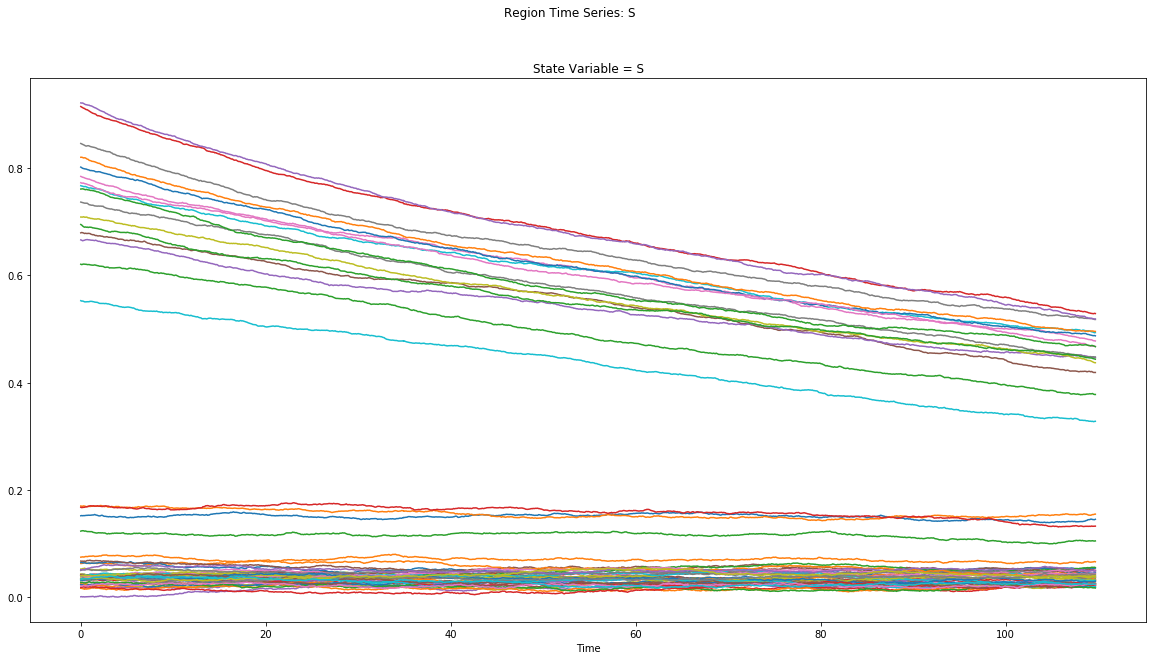

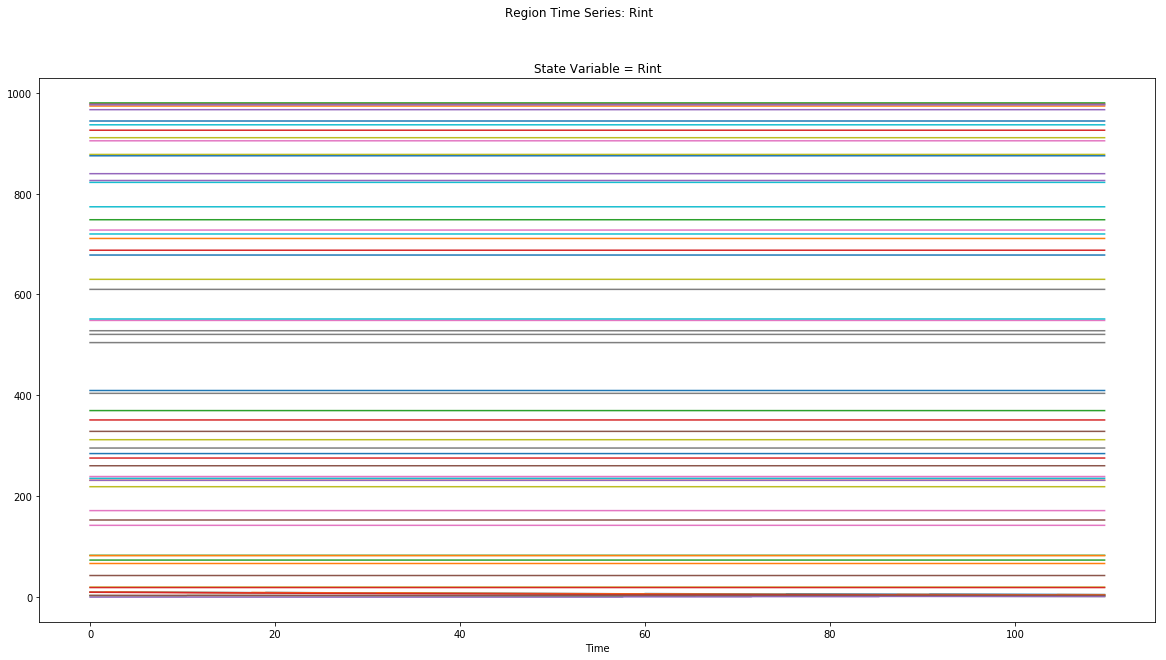

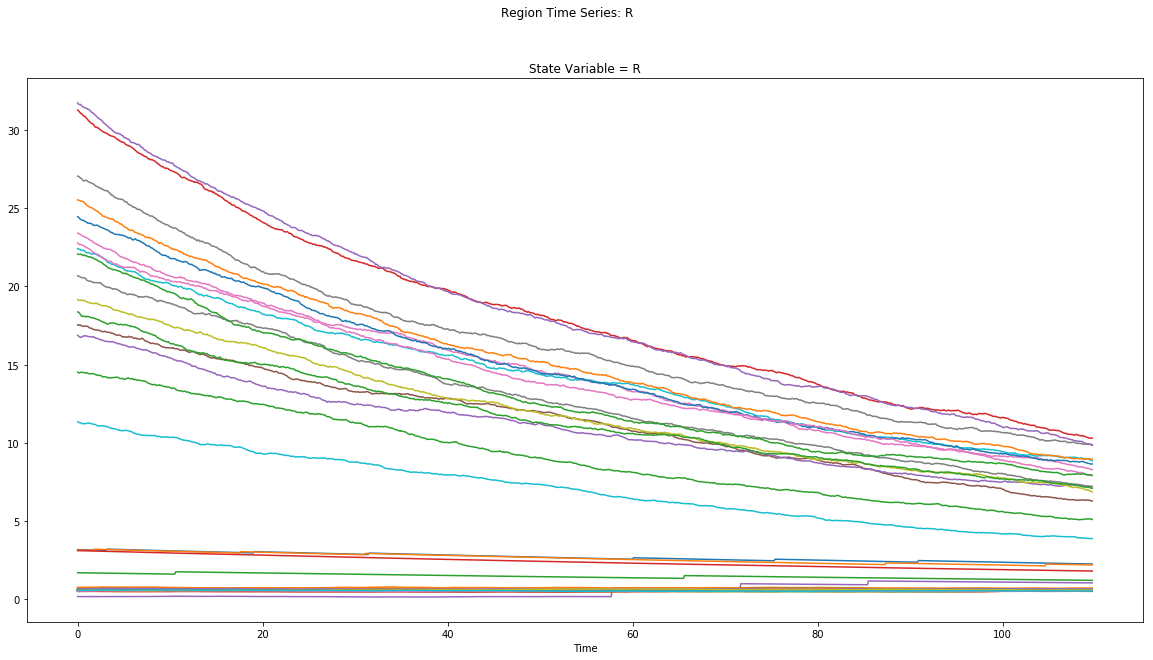

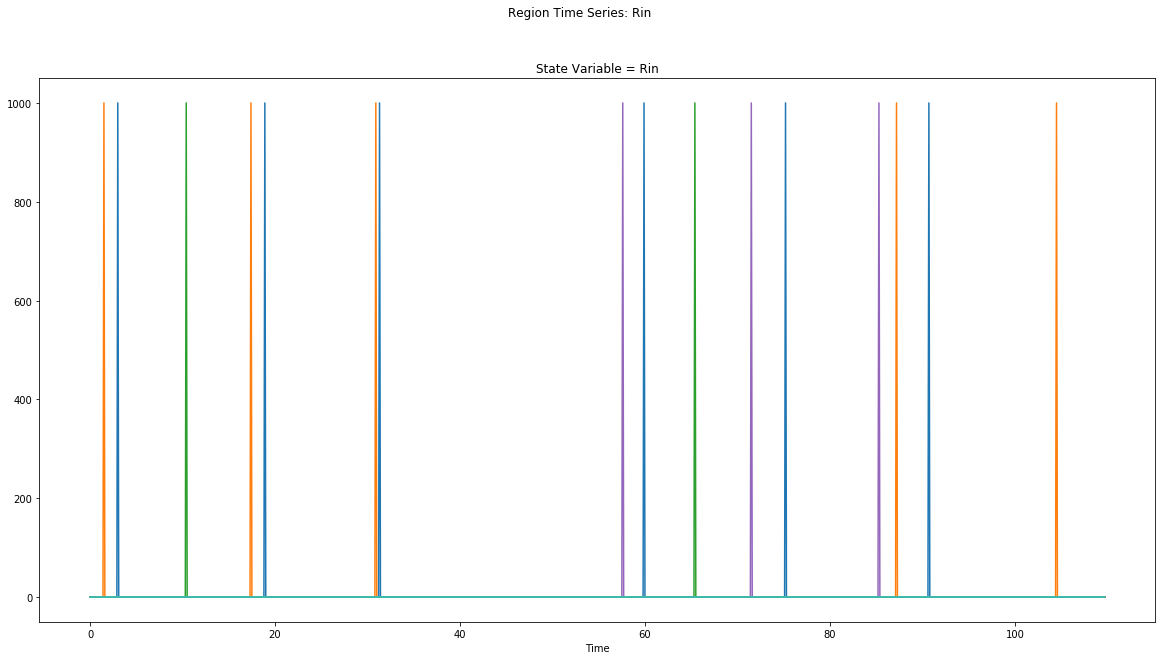

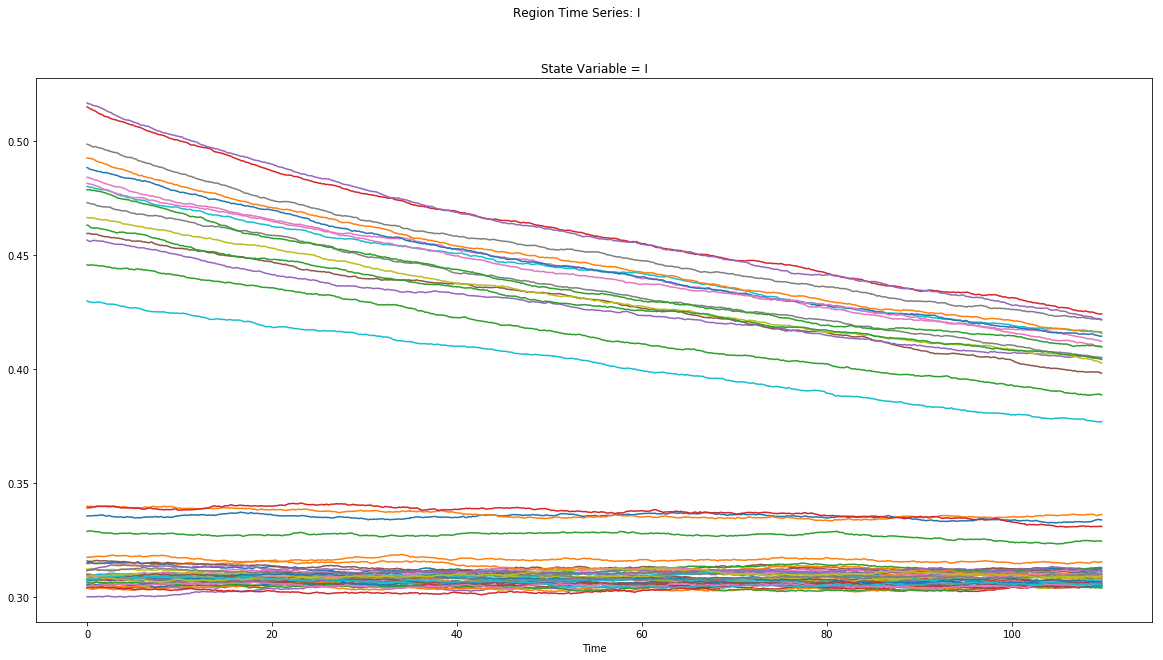

In [10]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [11]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-01-13 20:10:01,035 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:01,050 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:01,441 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:01,805 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:02,206 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:02,573 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


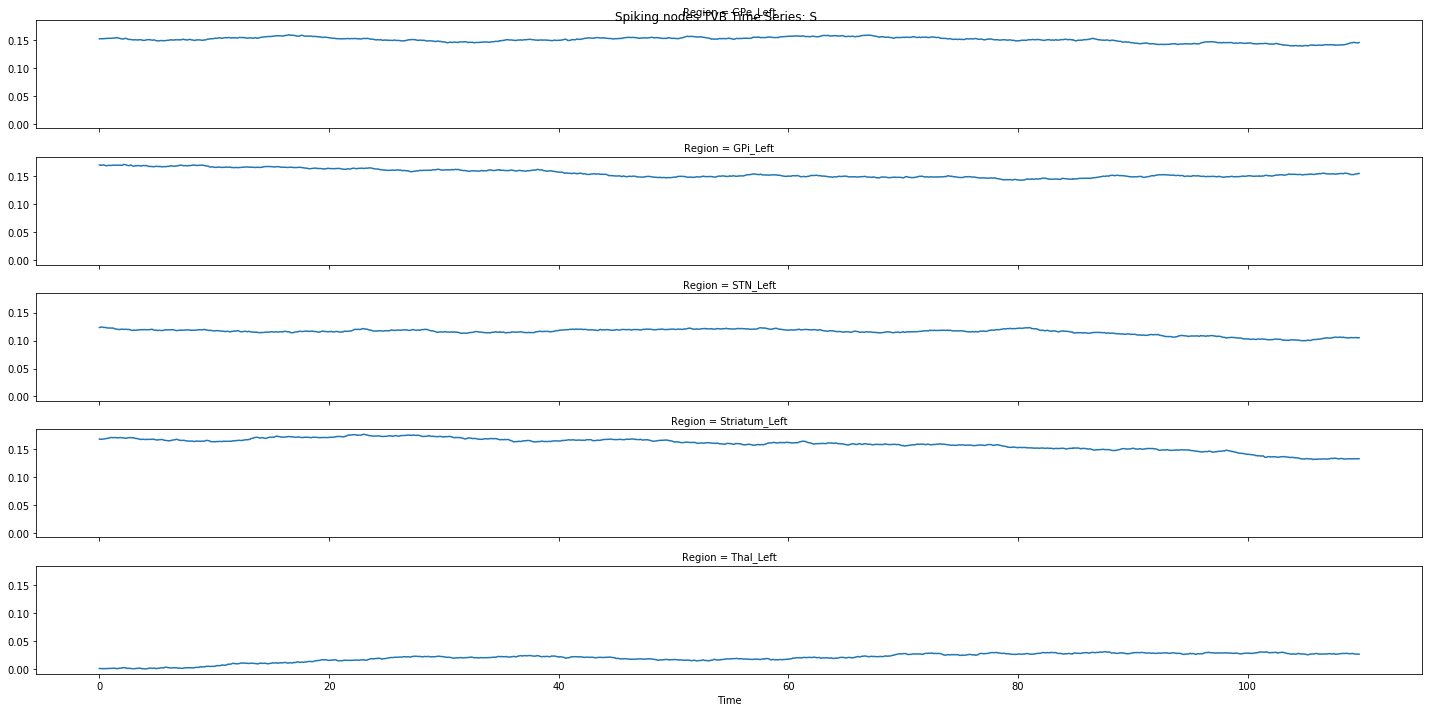

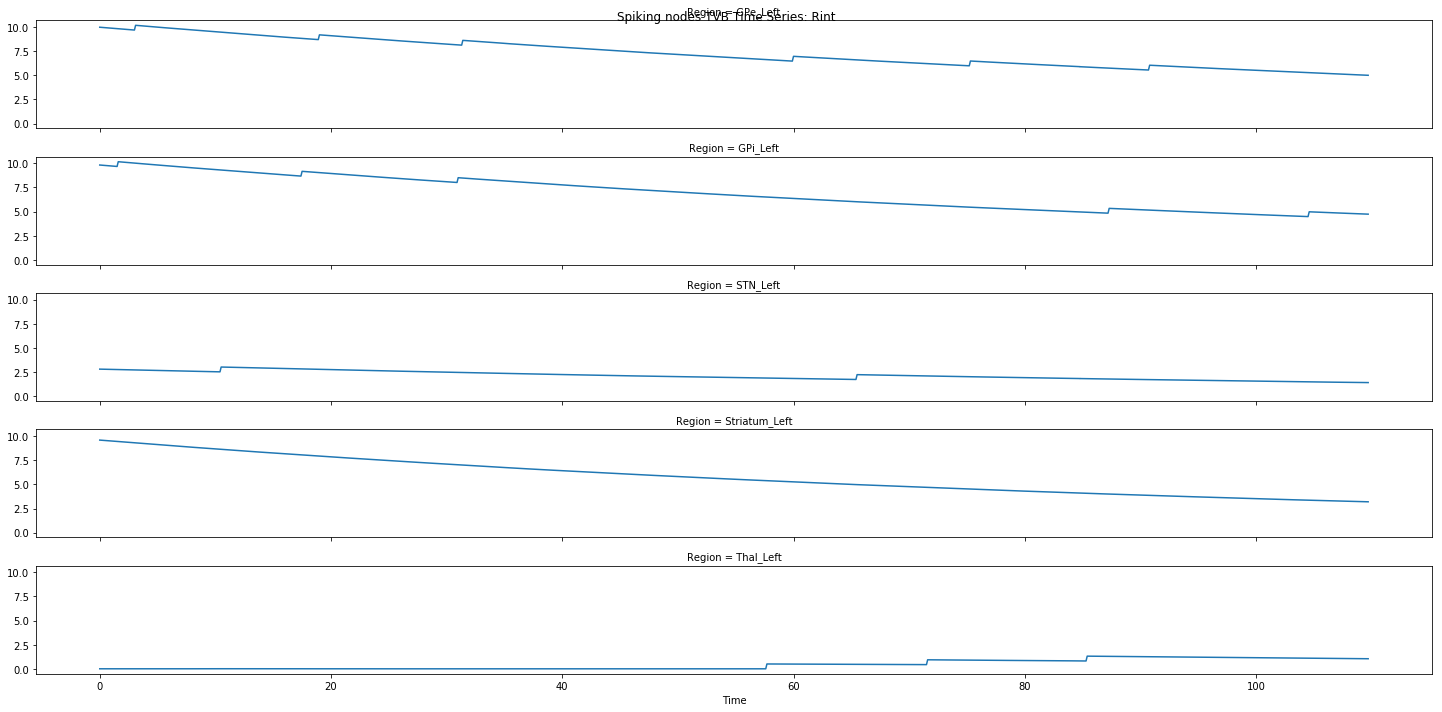

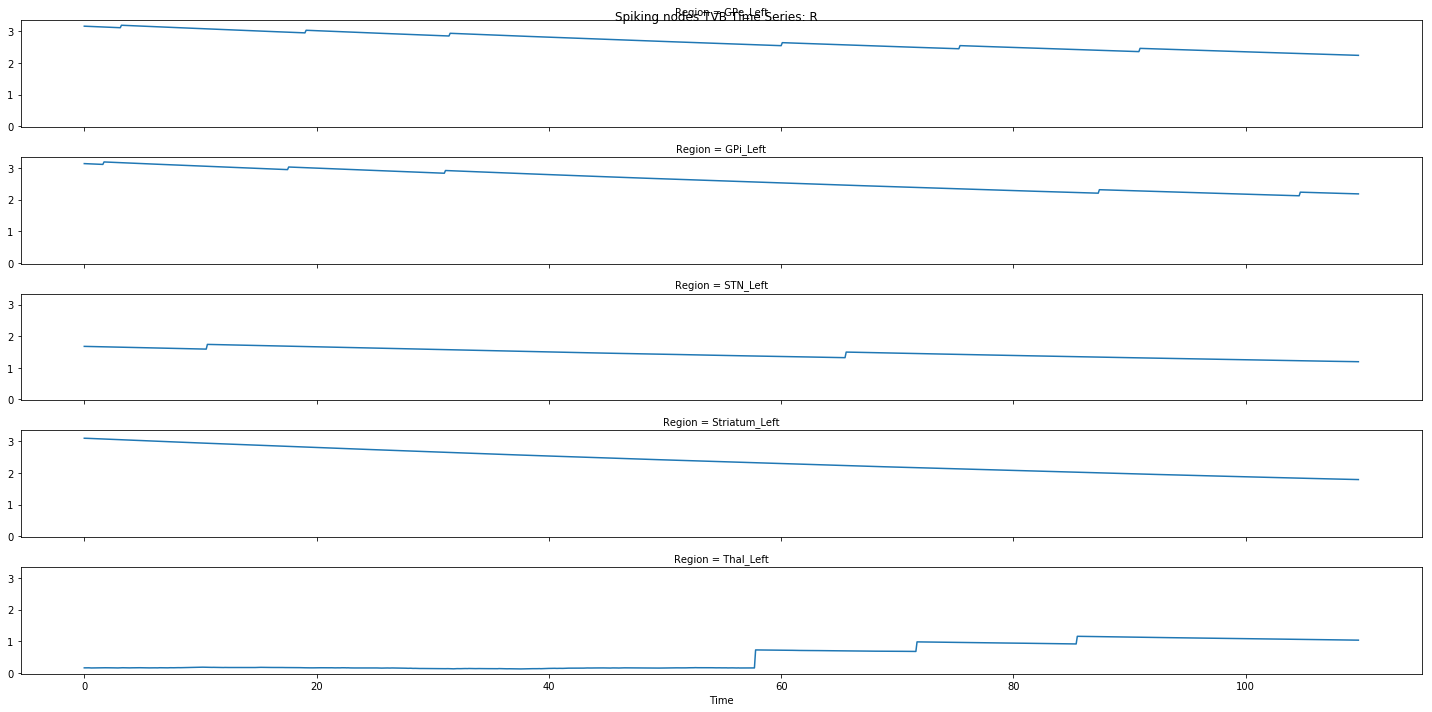

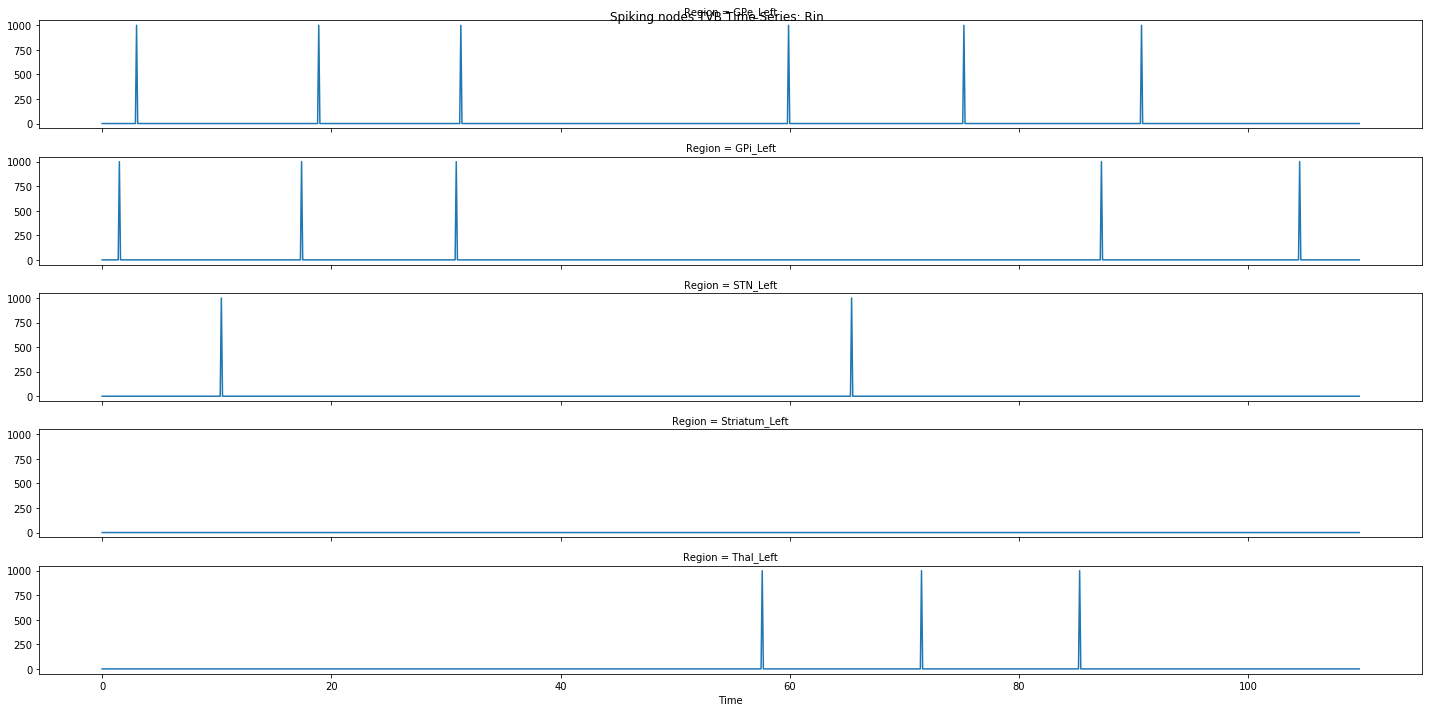

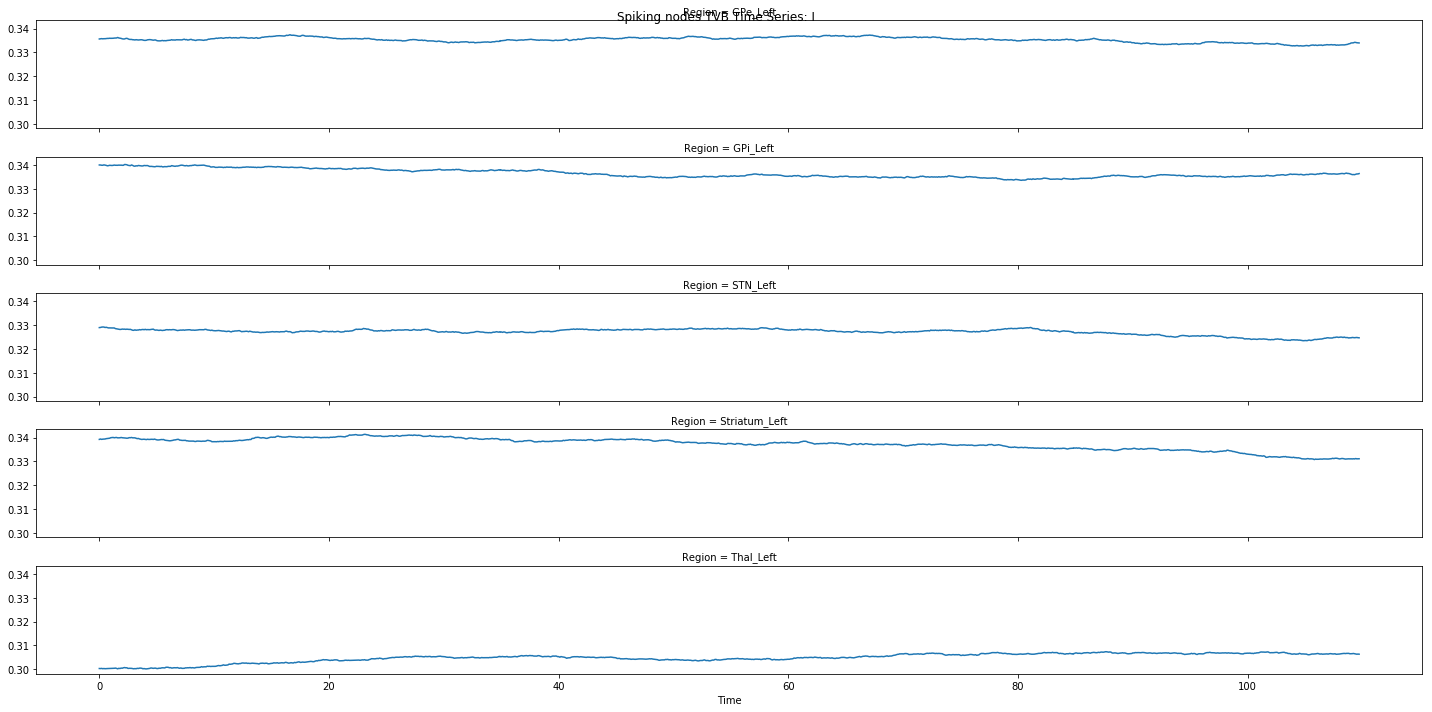

In [12]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [13]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [14]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [15]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [16]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:848: UserWarning: Binning discarded 200 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:529: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  'Detected empty spike trains (rows) in the binned_spiketrain.')
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:536: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 10.1010099 ,         nan, 30.30302969],
       [50.50504948, 40.40403959,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.        ,         nan],
       [        nan,         nan,         nan,  0.        ,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,  1.        ,         nan,
          -0.015625  ],
         [        nan,         nan,         nan,         nan,
                  nan],
 

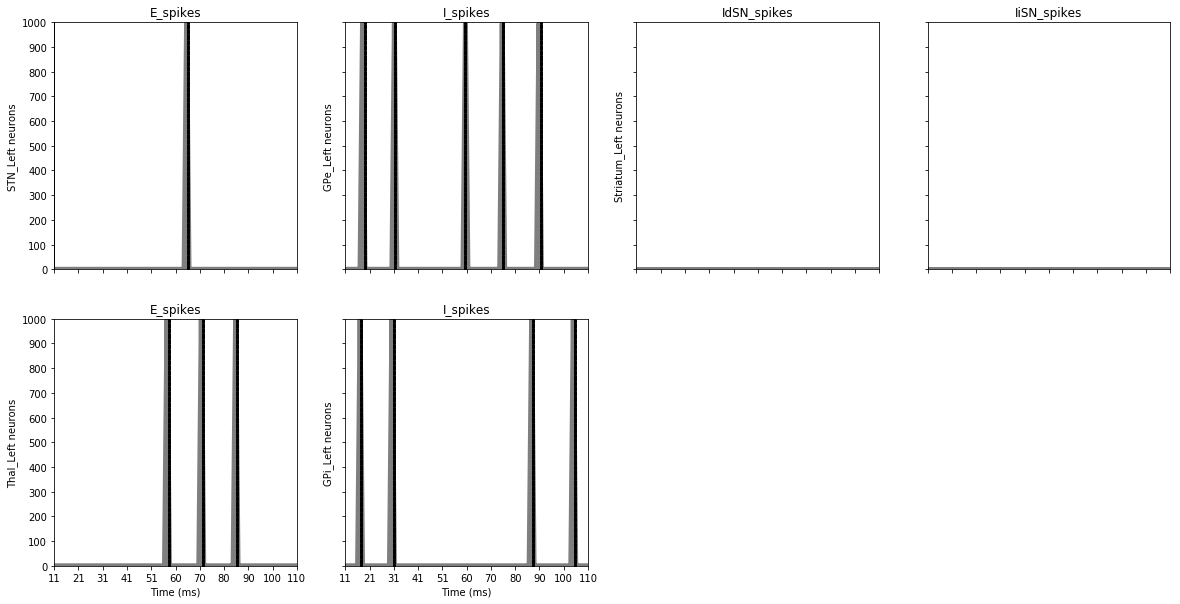

<Figure size 432x288 with 0 Axes>

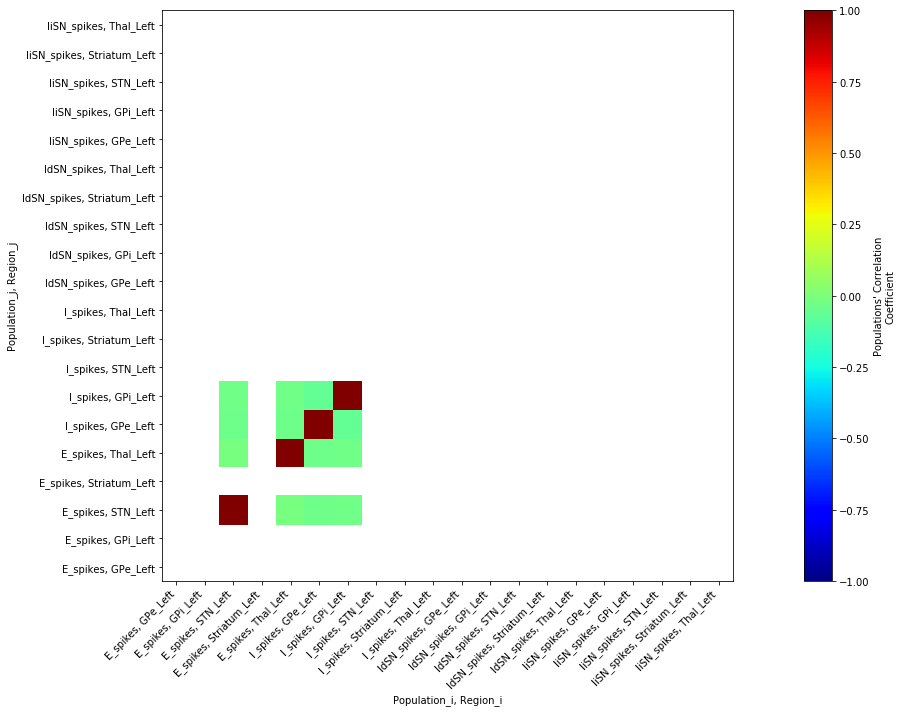

In [17]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"],
                                  figsize=FIGSIZE) #  
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [18]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-01-13 20:10:08,266 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/stim/res/Spikes.h5
2021-01-13 20:10:08,266 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/stim/res/Spikes.h5
2021-01-13 20:10:08,286 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-01-13 20:10:08,286 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-01-13 20:10:08,291 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-01-13 20:10:08,291 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a n

2021-01-13 20:10:08,442 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-01-13 20:10:08,442 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-01-13 20:10:08,449 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-01-13 20:10:08,449 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-01-13 20:10:08,467 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55
 57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55
 57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55 57.7  71.65 85.55
 57.7  71.65 85.55 57.7  71.65 85.55 57.

2021-01-13 20:10:08,475 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0   1   1   1   2   2   2   3   3   3   4   4   4   5   5   5
   6   6   6   7   7   7   8   8   8   9   9   9  10  10  10  11  11  11
  12  12  12  13  13  13  14  14  14  15  15  15  16  16  16  17  17  17
  18  18  18  19  19  19  20  20  20  21  21  21  22  22  22  23  23  23
  24  24  24  25  25  25  26  26  26  27  27  27  28  28  28  29  29  29
  30  30  30  31  31  31  32  32  32  33  33  33  34  34  34  35  35  35
  36  36  36  37  37  37  38  38  38  39  39  39  40  40  40  41  41  41
  42  42  42  43  43  43  44  44  44  45  45  45  46  46  46  47  47  47
  48  48  48  49  49  49  50  50  50  51  51  51  52  52  52  53  53  53
  54  54  54  55  55  55  56  56  56  57  57  57  58  58  58  59  59  59
  60  60  60  61  61  61  62  62  62  63  63  63  64  64  64  65  65  65
  66  66  66  67  

2021-01-13 20:10:08,527 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[  1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.9   87.45 104.7
   1.55  17.4   30.9   87.45 104.7    1.55  17.4   30.

2021-01-13 20:10:08,539 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0   0   0   1   1   1   1   1   2   2   2   2   2   3   3   3
   3   3   4   4   4   4   4   5   5   5   5   5   6   6   6   6   6   7
   7   7   7   7   8   8   8   8   8   9   9   9   9   9  10  10  10  10
  10  11  11  11  11  11  12  12  12  12  12  13  13  13  13  13  14  14
  14  14  14  15  15  15  15  15  16  16  16  16  16  17  17  17  17  17
  18  18  18  18  18  19  19  19  19  19  20  20  20  20  20  21  21  21
  21  21  22  22  22  22  22  23  23  23  23  23  24  24  24  24  24  25
  25  25  25  25  26  26  26  26  26  27  27  27  27  27  28  28  28  28
  28  29  29  29  29  29  30  30  30  30  30  31  31  31  31  31  32  32
  32  32  32  33  33  33  33  33  34  34  34  34  34  35  35  35  35  35
  36  36  36  36  36  37  37  37  37  37  38  38  38  38  38  39  39  39
  39  39  40  40  4

2021-01-13 20:10:08,628 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-01-13 20:10:08,633 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population' 'Region'] !

2021-01-13 20:10:08,633 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population' 'Region'] !

2021-01-13 20:10:08,637 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[        nan         nan 10.1010099          nan 30.30302969]
 [50.50504948 40.40403959         nan         nan         nan]
 [        nan         nan         nan  0.                 nan]
 [        nan         nan         nan  0.             

2021-01-13 20:10:08,884 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[        nan         nan         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [        nan         nan  1.                 nan -0.015625  ]
   [        nan         nan         nan         nan         nan]
   [        nan         nan -0.015625           nan  1.        ]]

  [[        nan         nan         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [-0.03200922 -0.02749633         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [-0.03200922 -0.02749633         nan         nan         nan]]

  [[        nan         nan         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [        nan        

2021-01-13 20:10:08,928 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-01-13 20:10:08,928 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-01-13 20:10:08,931 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-01-13 20:10:08,931 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-01-13 20:10:08,935 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_j" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_j'] !

2021-01-13 20:10:08,935 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_j" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_j'] !

2021-01-13 20:10:08,940 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

2021-01-13 20:10:09,737 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:10,369 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:10,967 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:11,572 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:12,220 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:12,868 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-13 20:10:13,567 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

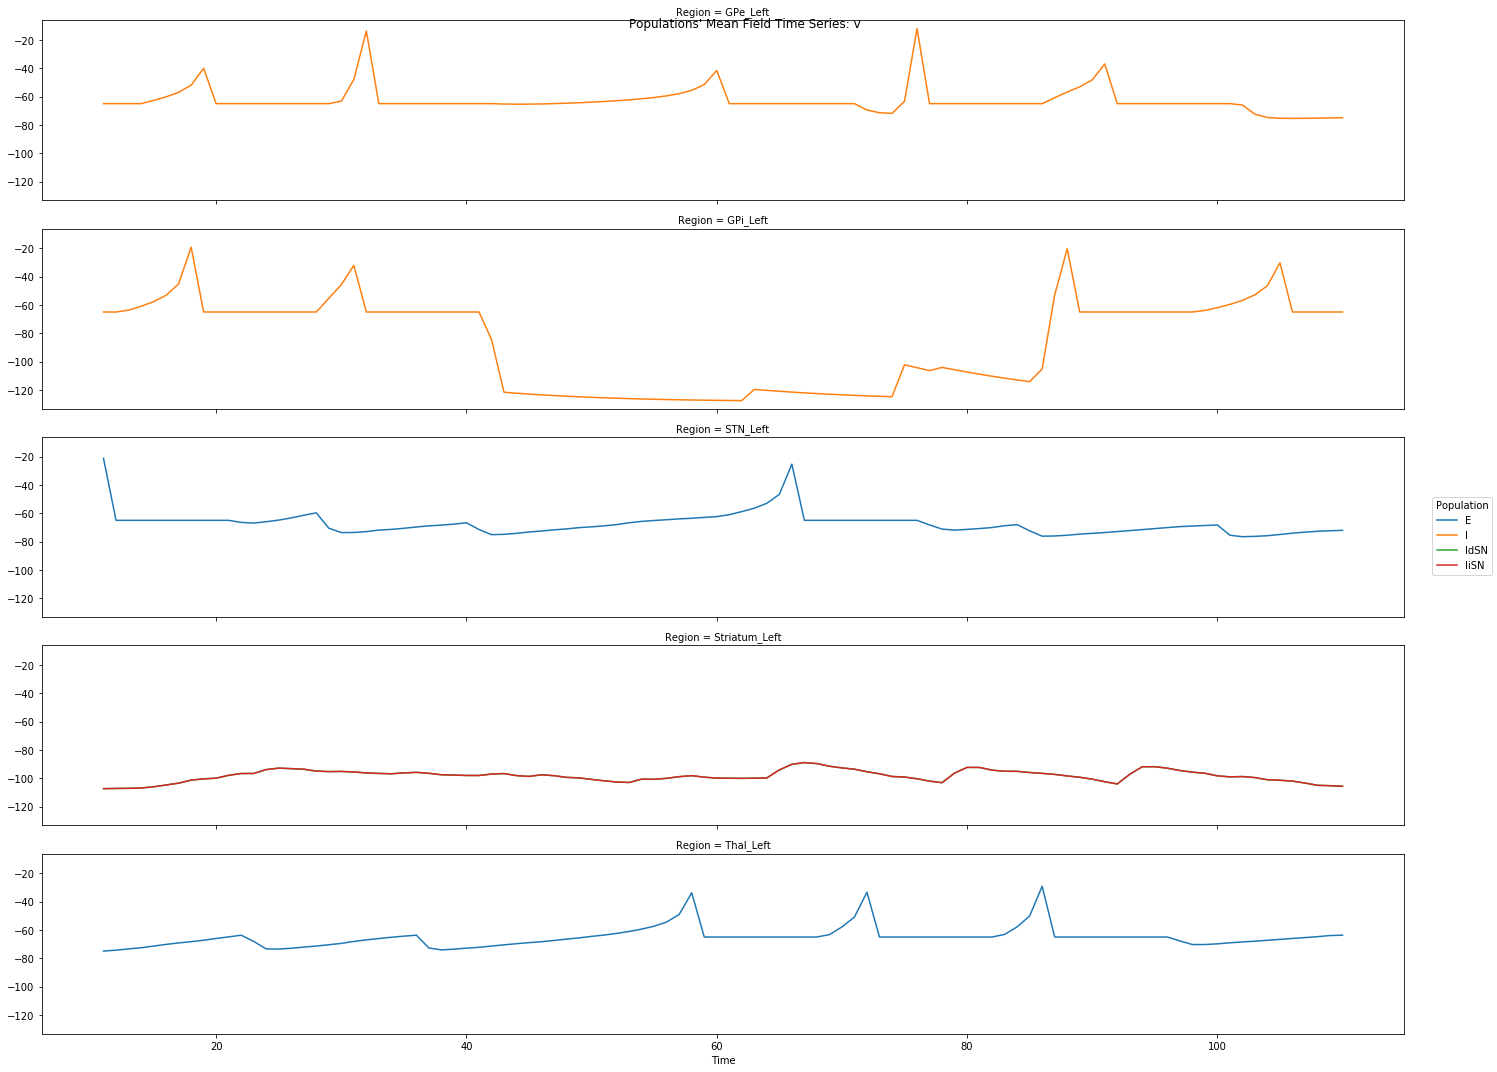

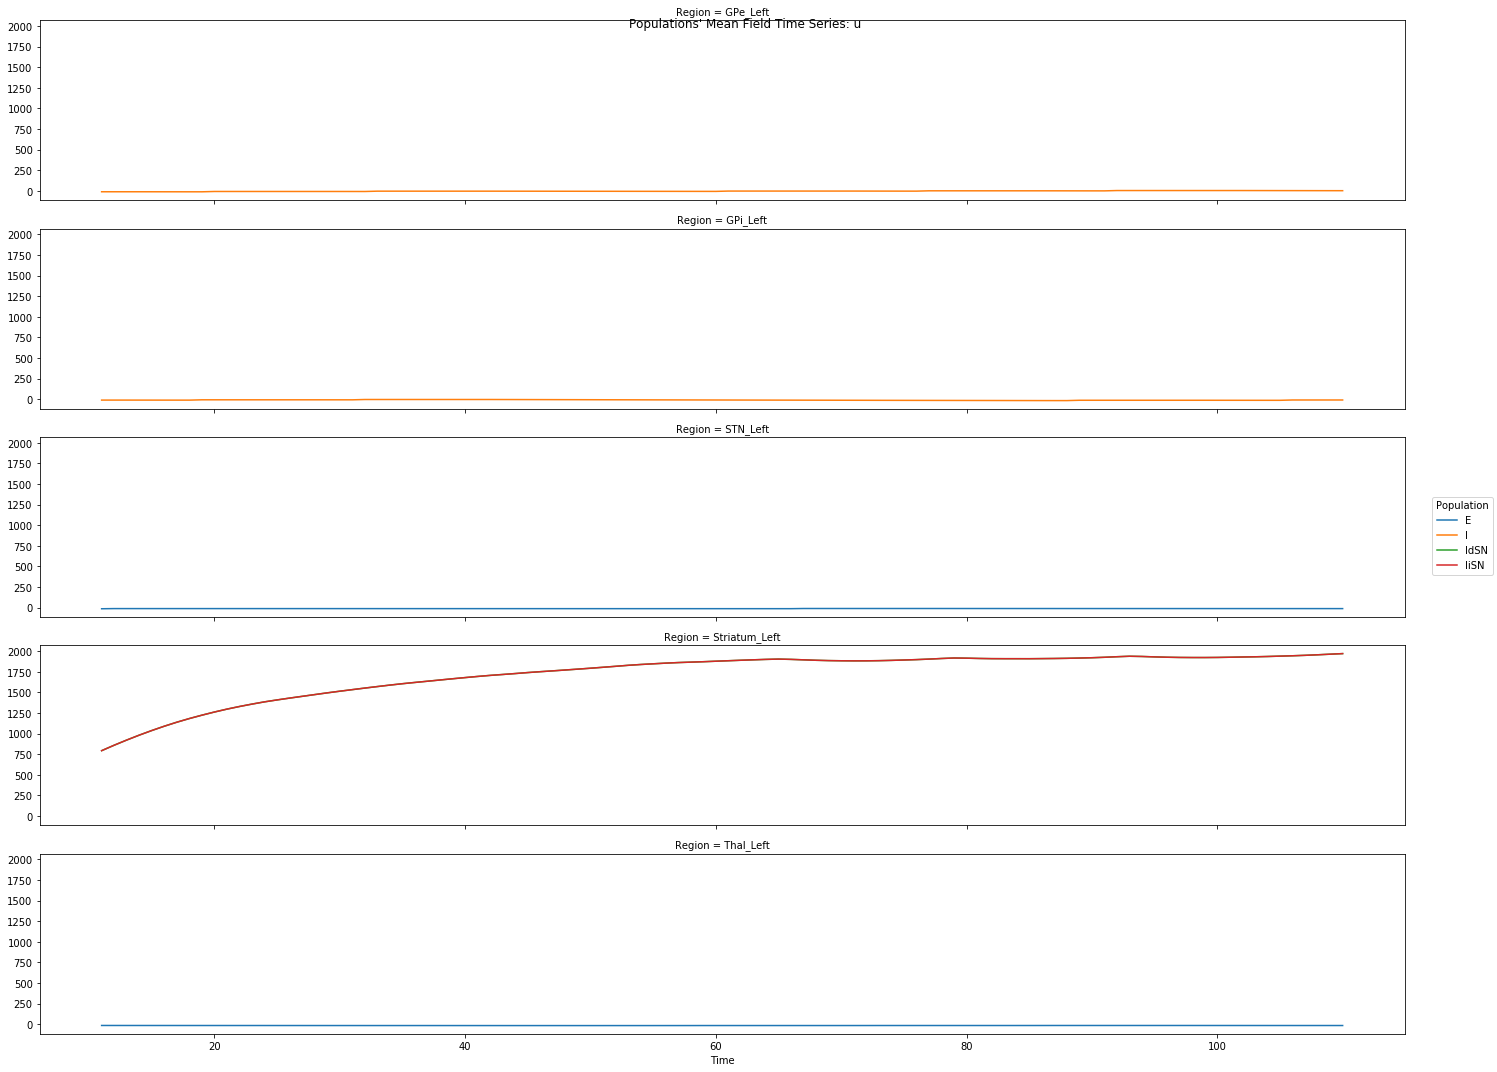

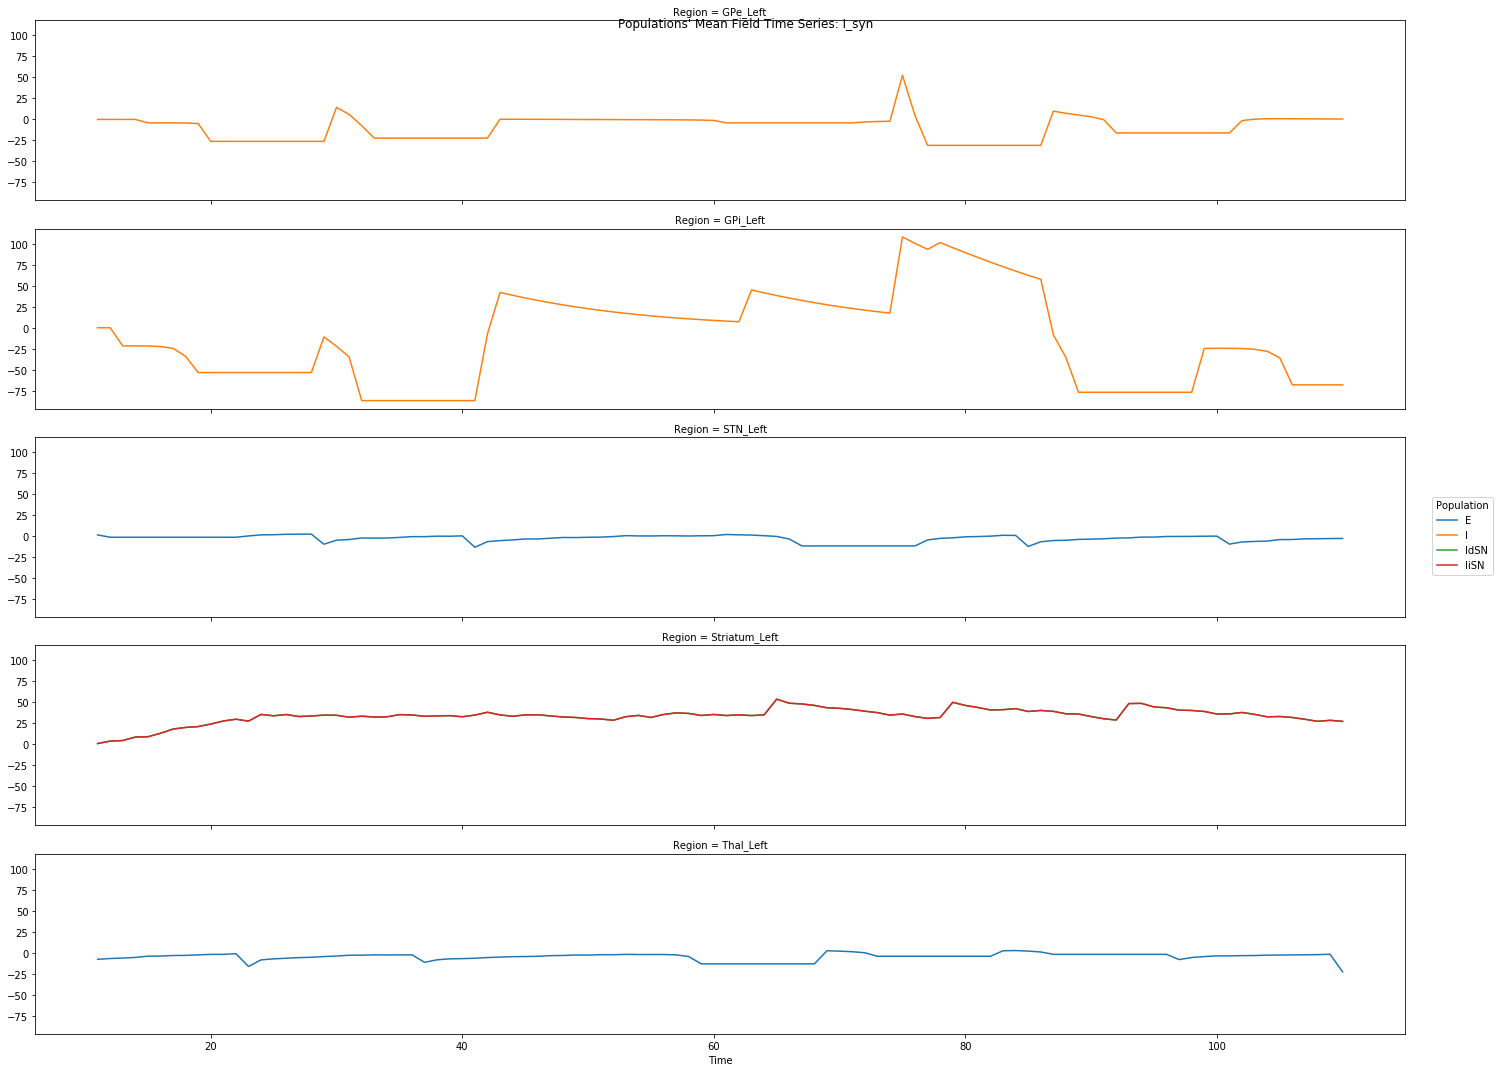

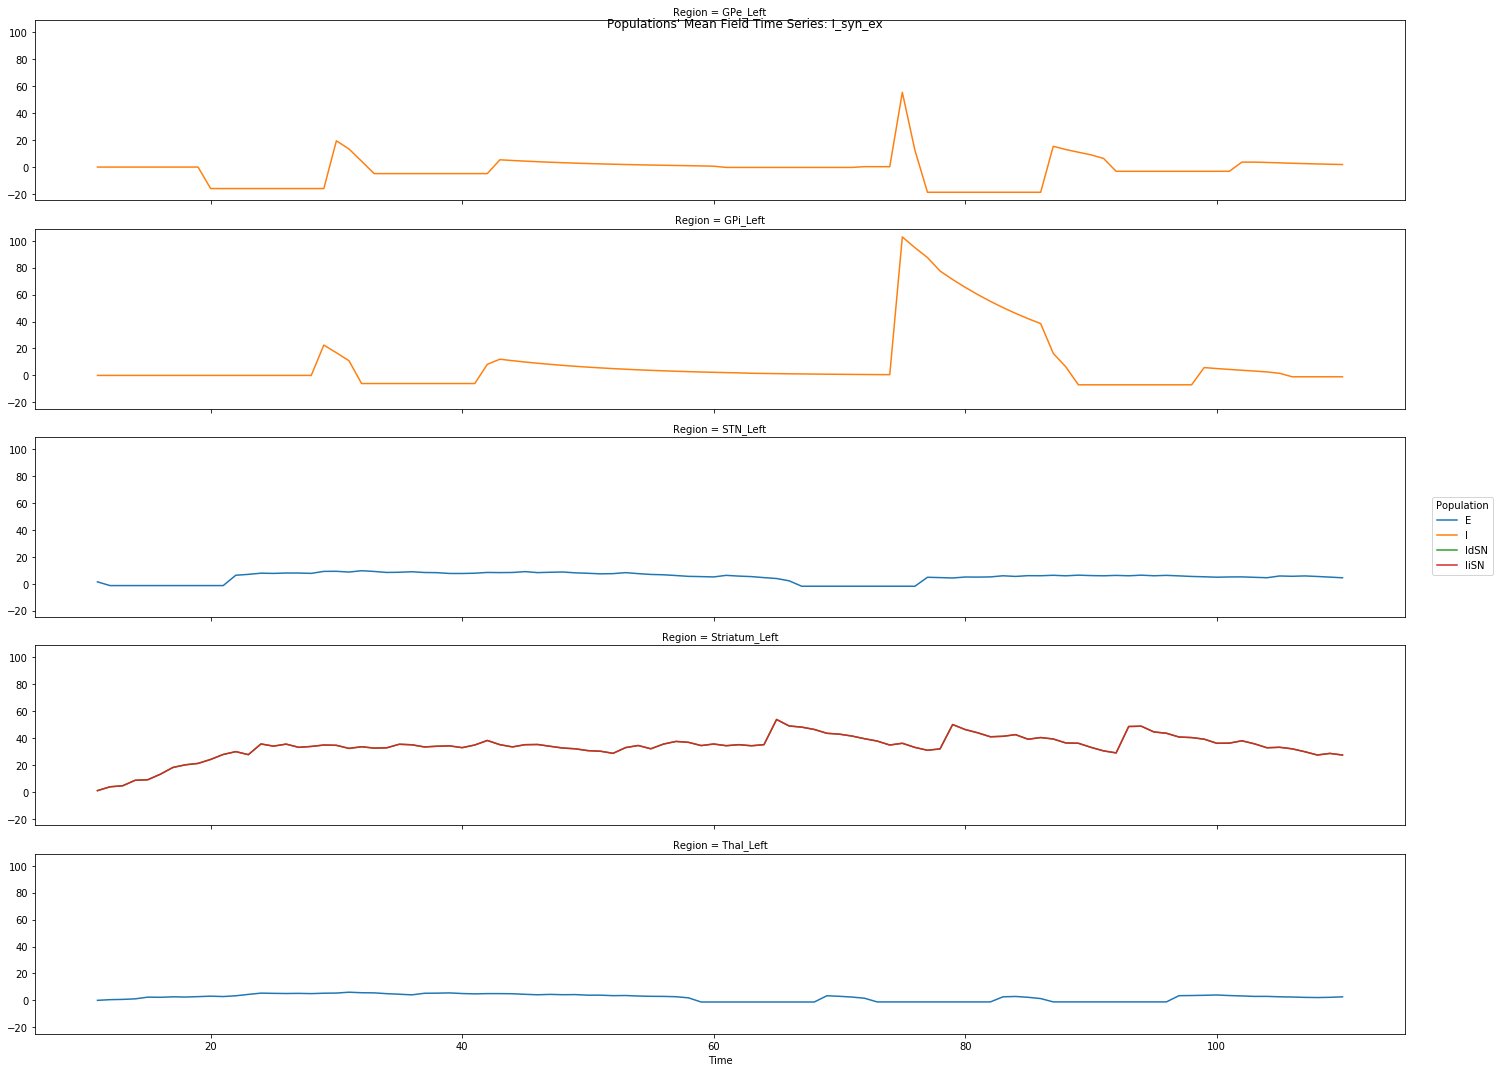

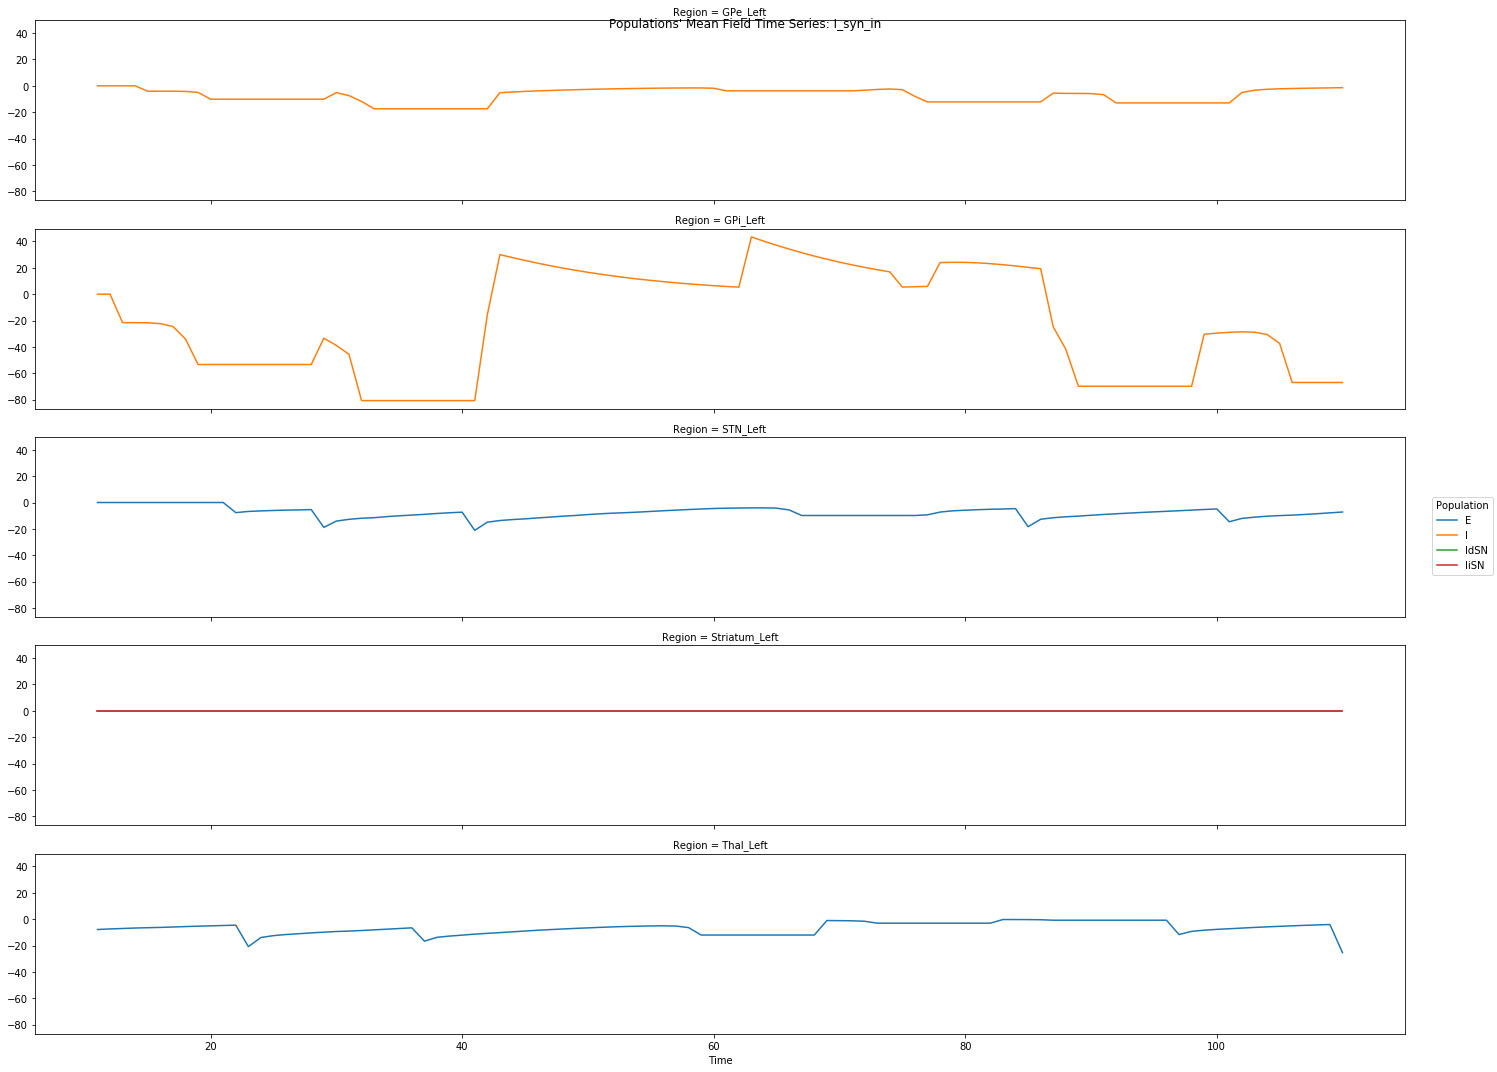

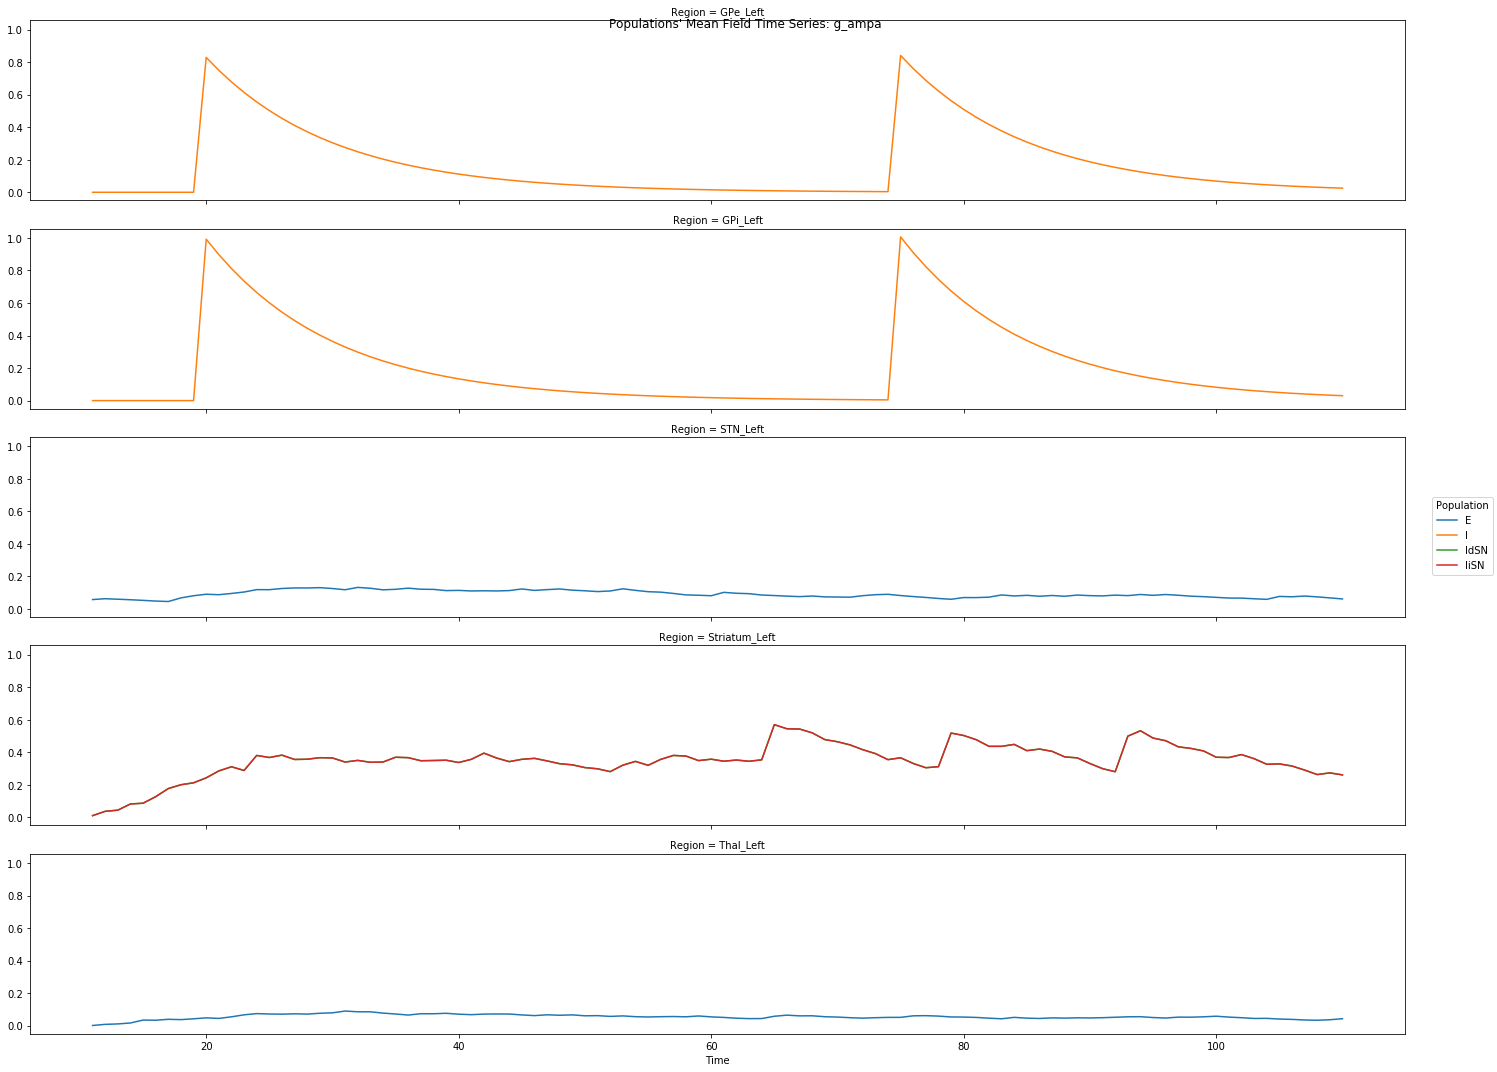

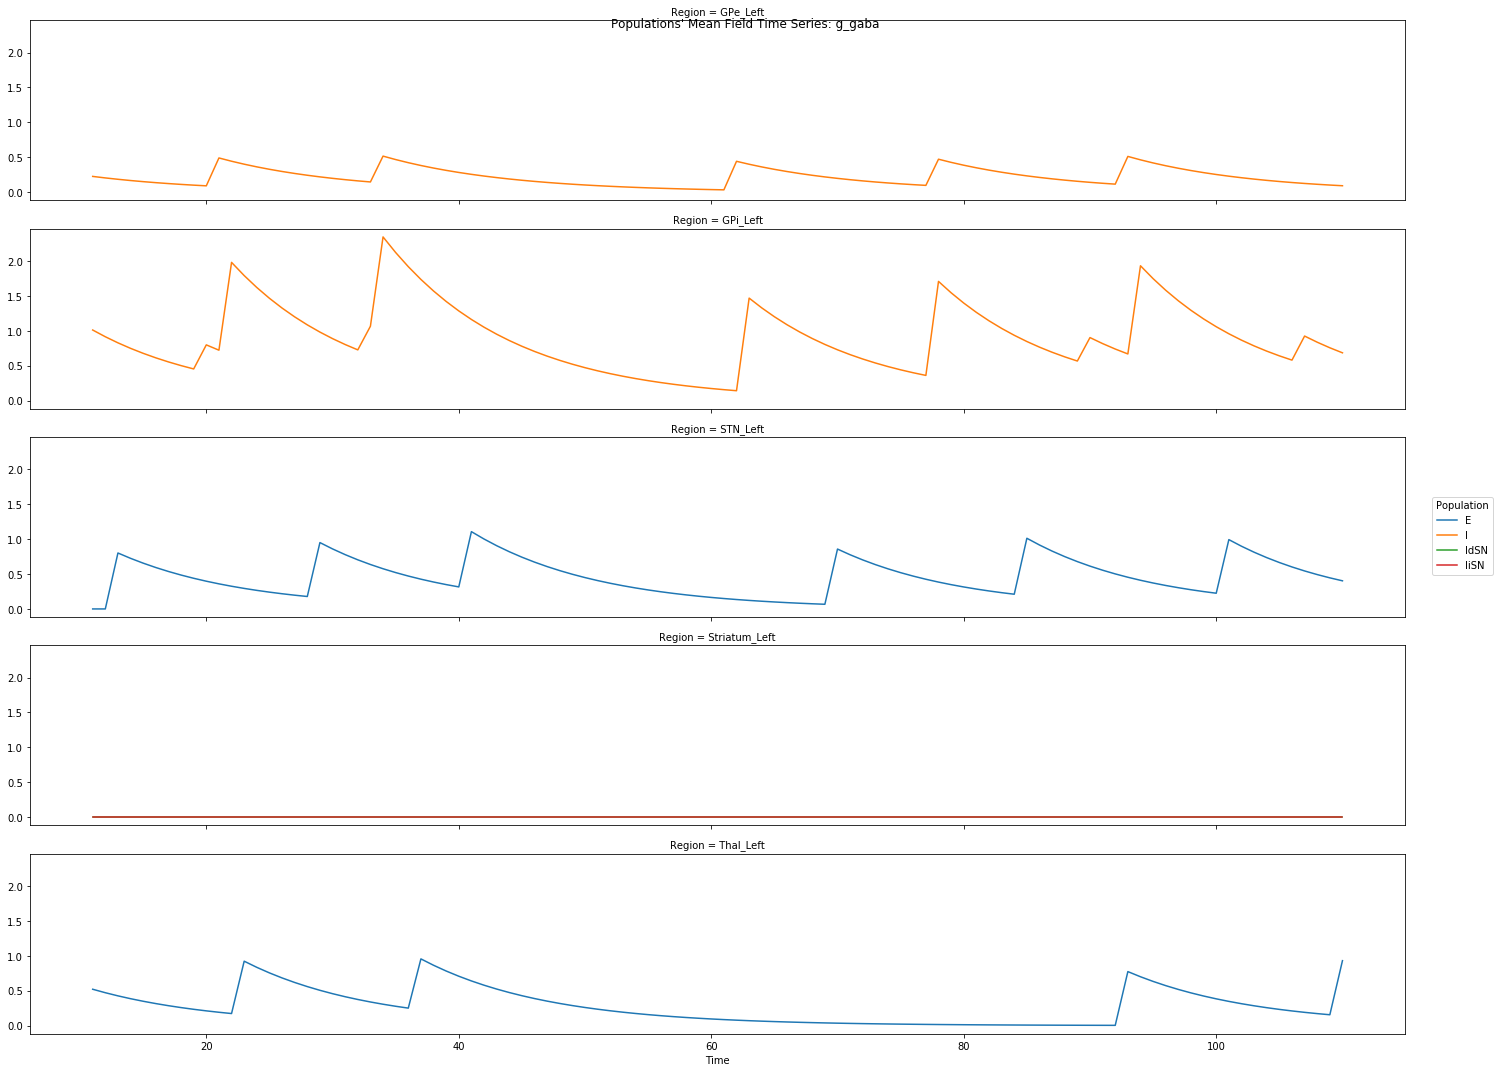

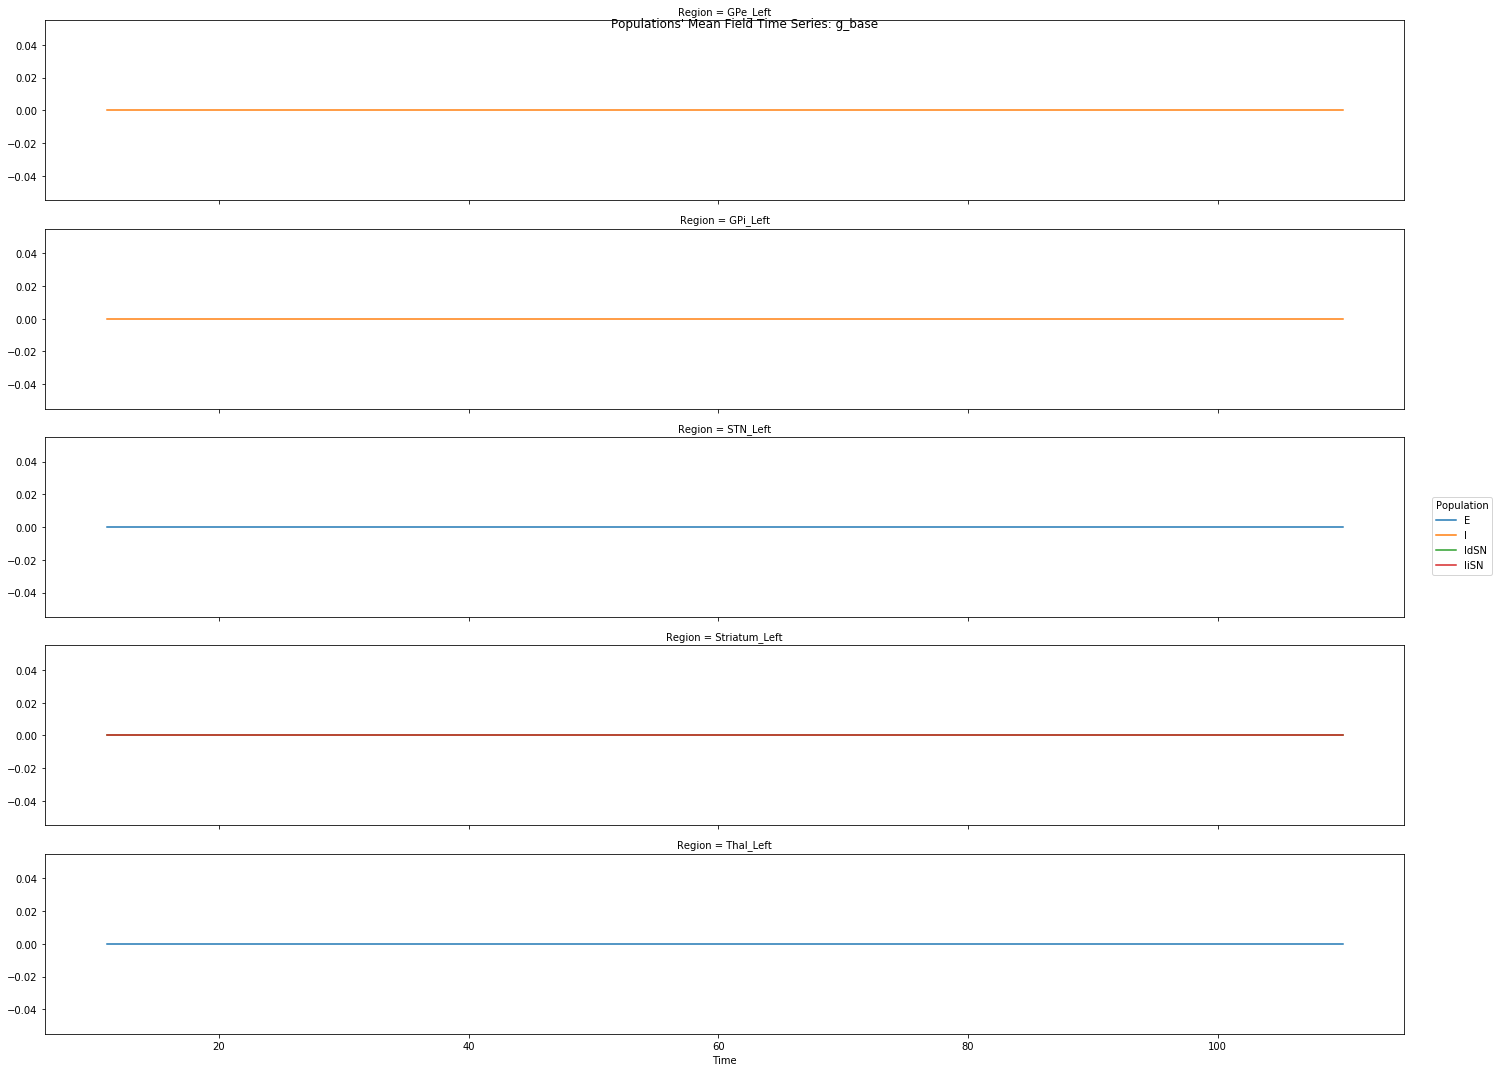

In [19]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [20]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [21]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [22]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868